In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/plays2022.csv')
threshold = 30
off_counts = df['offense_idx'].value_counts()
def_counts = df['defense_idx'].value_counts()
valid_off_teams = off_counts[off_counts >= threshold].index
valid_def_teams = def_counts[def_counts >= threshold].index

df_filtered = df[df['offense_idx'].isin(valid_off_teams) & df['defense_idx'].isin(valid_def_teams)].copy()
print("Total plays after filtering:", len(df_filtered))
exclude_types = ['Punt', 'Field Goal Good', 'Field Goal Missed', 'Kickoff']

df_filtered = df_filtered[~df_filtered['play_type'].isin(exclude_types)].copy()

print("Total plays before filtering:", len(df))
print("Total plays after filtering:", len(df_filtered))
print(df_filtered['play_type'].unique())
print(df.info())

Total plays after filtering: 152806
Total plays before filtering: 152806
Total plays after filtering: 135919
['Pass Incompletion' 'Pass Reception' 'Rush' 'Penalty' 'Rushing Touchdown'
 'Kickoff Return (Offense)' 'Timeout' 'Passing Touchdown'
 'Fumble Return Touchdown' 'End Period' 'Fumble Recovery (Own)'
 'End of Half' 'Sack' 'End of Game' 'Pass Interception Return'
 'Blocked Punt' 'Fumble Recovery (Opponent)' 'Interception'
 'Kickoff Return Touchdown' 'Blocked Punt Touchdown' 'Blocked Field Goal'
 'Uncategorized' 'Punt Return Touchdown' 'Interception Return Touchdown'
 'End of Regulation' 'Two Point Rush' 'Two Point Pass' 'Safety'
 'Missed Field Goal Return' 'Blocked Field Goal Touchdown' 'Pass'
 'Defensive 2pt Conversion']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152806 entries, 0 to 152805
Data columns (total 44 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                     

In [2]:
df_4th = df_filtered[df_filtered['down'] == 4].copy()
print("Total 4th down plays:", len(df_4th))

df_4th['fourth_down_success'] = (df_4th['yards_gained'] > df_4th['distance'])
print("Unique classes in fourth_down_success:", df_4th['fourth_down_success'].unique())
print("Value counts:\n", df_4th['fourth_down_success'].value_counts())

df_train = df_4th[df_4th['week'] < 9].copy() 
df_test  = df_4th[df_4th['week'] > 8].copy()  
print("Training 4th down plays:", len(df_train))
print("Testing 4th down plays:", len(df_test))

Total 4th down plays: 5954
Unique classes in fourth_down_success: [False  True]
Value counts:
 fourth_down_success
False    4106
True     1848
Name: count, dtype: int64
Training 4th down plays: 3737
Testing 4th down plays: 2217


In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

X_train = df_train[['yards_to_goal', 'distance']]
X_test  = df_test[['yards_to_goal', 'distance']]
y_train = df_train['fourth_down_success']
y_test  = df_test['fourth_down_success']

print("Unique classes in y_train:", y_train.unique())
print("Value counts in y_train:\n", y_train.value_counts())
print("Unique classes in y_train:", y_train.unique())

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search_1 = GridSearchCV(
    LogisticRegression(max_iter=1000, solver='liblinear'),
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid_search_1.fit(X_train, y_train)

print("Best parameters for Model 1:", grid_search_1.best_params_)

Unique classes in y_train: [False  True]
Value counts in y_train:
 fourth_down_success
False    2587
True     1150
Name: count, dtype: int64
Unique classes in y_train: [False  True]
Best parameters for Model 1: {'C': 0.001}


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error


model = LogisticRegression(max_iter=1000, C=grid_search_1.best_params_['C'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_prob))
print("\nModel (4th down success without Team Coefficients):")
print("Test Accuracy:", round(acc, 3)*100, "%")
print("Test RMSE:", round(rmse, 3))


Model (4th down success without Team Coefficients):
Test Accuracy: 68.5 %
Test RMSE: 0.457


In [5]:
import pandas as pd

df_for_prediction = df_4th.dropna(subset=['yards_to_goal', 'distance']).copy()
print("Number of drives used for prediction:", len(df_for_prediction))

df_for_prediction['predicted_prob'] = model.predict_proba(
    df_for_prediction[['yards_to_goal', 'distance']]
)[:, 1]

team_predictions = df_for_prediction.groupby('offense').agg(
    total_attempts=('fourth_down_success', 'count'),
    actual_conversion_rate=('fourth_down_success', 'mean'),
    avg_predicted_prob=('predicted_prob', 'mean')
).reset_index()

team_predictions['actual_conversion_rate'] = team_predictions['actual_conversion_rate'] * 100
team_predictions['avg_predicted_prob'] = team_predictions['avg_predicted_prob'] * 100

team_predictions['actual_conversion_rate'] = team_predictions['actual_conversion_rate'].map("{:.2f}%".format)
team_predictions['avg_predicted_prob'] = team_predictions['avg_predicted_prob'].map("{:.2f}%".format)

team_predictions.to_csv("../results/4Th_Down_Without_Team_Coeff/2022.csv", index=False)
print("Team-level fourth down conversion predictions saved to 'team_fourth_down_conversion_predictions_without_team_coefficients.csv'")
print(team_predictions.head())

Number of drives used for prediction: 5954
Team-level fourth down conversion predictions saved to 'team_fourth_down_conversion_predictions_without_team_coefficients.csv'
             offense  total_attempts actual_conversion_rate avg_predicted_prob
0  Abilene Christian               4                 25.00%             42.14%
1          Air Force              31                 51.61%             33.73%
2              Akron              34                 35.29%             30.87%
3            Alabama              36                 41.67%             31.70%
4        Alabama A&M               7                 28.57%             33.31%


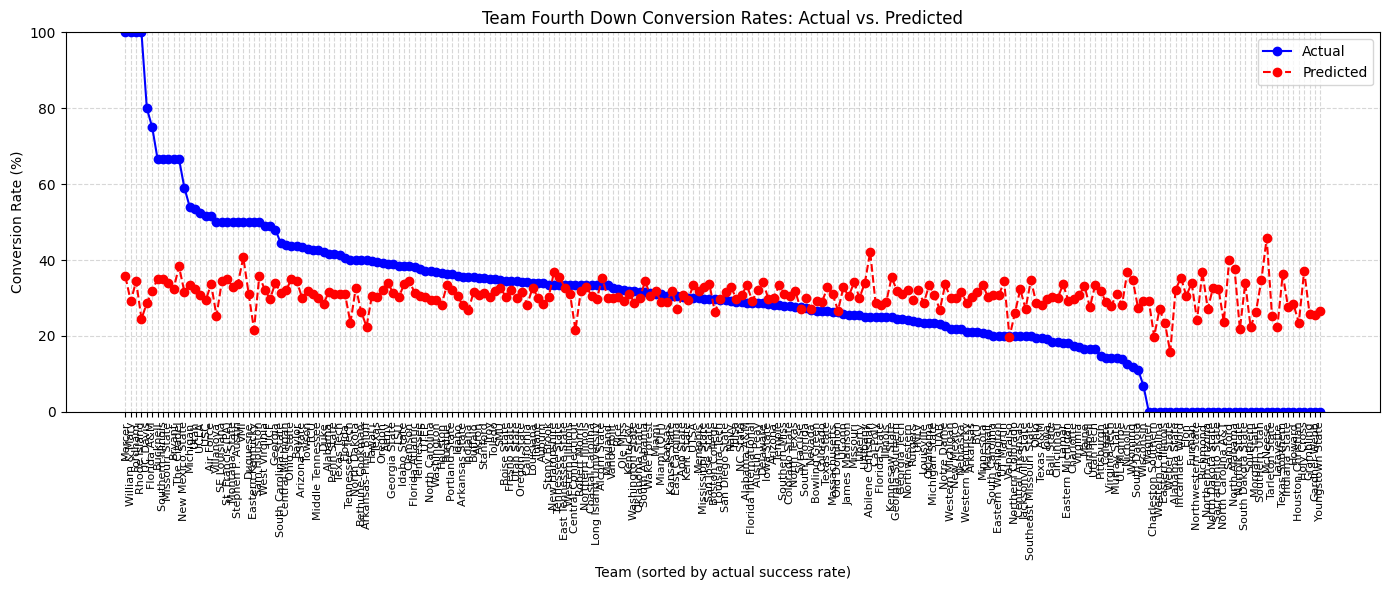

In [6]:
import matplotlib.pyplot as plt
import numpy as np

df_team = team_predictions.copy()

df_team['actual_conversion_rate_numeric'] = df_team['actual_conversion_rate'].str.rstrip('%').astype(float)
df_team['avg_predicted_prob_numeric'] = df_team['avg_predicted_prob'].str.rstrip('%').astype(float)

df_team = df_team.sort_values(by='actual_conversion_rate_numeric', ascending=False).reset_index(drop=True)

x = np.arange(len(df_team))

plt.figure(figsize=(14, 6))
plt.plot(x, df_team['actual_conversion_rate_numeric'], color='blue', linestyle='-', marker='o', label='Actual')
plt.plot(x, df_team['avg_predicted_prob_numeric'], color='red', linestyle='--', marker='o', label='Predicted')

plt.xlabel("Team (sorted by actual success rate)")
plt.ylabel("Conversion Rate (%)")
plt.title("Team Fourth Down Conversion Rates: Actual vs. Predicted")
plt.xticks(x, df_team['offense'], rotation=90, fontsize=8)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()